In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Tải mô hình đã huấn luyện
model_lstm = load_model('/content/drive/MyDrive/Colab_Notebooks/deep_learning/ImageCaptionv2/image_captioning_model.keras')

# Load từ điển từ/idx và idx/to từ
with open('/content/drive/MyDrive/Colab_Notebooks/deep_learning/ImageCaptionv2/word_to_idx.json', 'r') as f:
    word_to_idx = json.load(f)

with open('/content/drive/MyDrive/Colab_Notebooks/deep_learning/ImageCaptionv2/idx_to_word.json', 'r') as f:
    idx_to_word = json.load(f)

# Chuẩn bị mô hình CNN với InceptionV3
model_cnn = InceptionV3(weights='imagenet')
model_cnn = Model(model_cnn.input, model_cnn.layers[-2].output)

# Đặt các thông số cần thiết
max_len = 49

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Hàm tiền xử lý ảnh
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode_image(img_path):
    img = preprocess_image(img_path)
    feature_vector = model_cnn.predict(img, verbose=0)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
def predict_caption(photo):
    in_text = 'startseq'
    for _ in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        yhat = model_lstm.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word.get(str(yhat))
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

2048


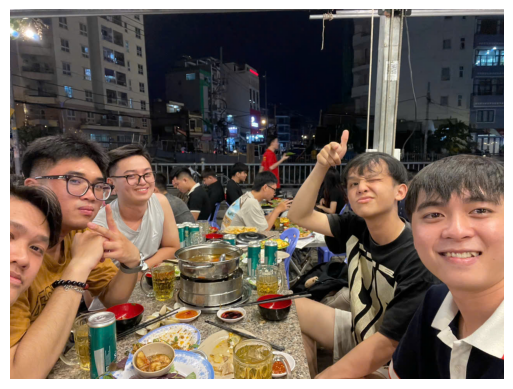

group of people sitting around table with food


In [ ]:
encoding_test_indiv = {}

img = '/content/drive/MyDrive/Colab_Notebooks/deep_learning/IC/ma_men.jpg'#.format(test[ix])

encoding_test_indiv[0] = encode_image(img)


print(len(encoding_test_indiv[0]))
photo = encoding_test_indiv[0].reshape((1,2048))

i = plt.imread(img)
plt.imshow(i)
plt.axis("off")
plt.show()

caption = predict_caption(photo)
print(caption)

2048


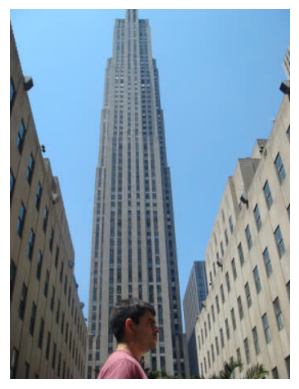

man flying through the air while holding kite


In [ ]:
encoding_test_indiv = {}

img = '/content/drive/MyDrive/Colab_Notebooks/deep_learning/IC/z6549984974470_4446f9beec55cd766100893c0b43c4e6.jpg'#.format(test[ix])

encoding_test_indiv[0] = encode_image(img)


print(len(encoding_test_indiv[0]))
photo = encoding_test_indiv[0].reshape((1,2048))

i = plt.imread(img)
plt.imshow(i)
plt.axis("off")
plt.show()

caption = predict_caption(photo)
print(caption)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smooth = SmoothingFunction().method1  # hoặc thử method2, method3 tùy tình huống

actual = [[
    "man stands in front of very tall building".split()
]]

predicted = [
    "man flying through the air while holding kite".split()
]

# Tính BLEU có smoothing
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0.0, 0.0, 0.0), smoothing_function=smooth)
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0.0, 0.0), smoothing_function=smooth)
bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33), smoothing_function=smooth)
bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)

BLEU-1: 0.125000
BLEU-2: 0.042258
BLEU-3: 0.032085
BLEU-4: 0.027776


In [ ]:
import collections

In [ ]:
import kagglehub

# Tải bộ dữ liệu COCO 2017 từ Kaggle
coco_image_caption_path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')

print('Data source import complete.')

Data source import complete.


In [ ]:
print(coco_image_caption_path)

/kaggle/input/coco-2017-dataset


In [ ]:
dataset_text = "/kaggle/input/coco-2017-dataset/coco2017/annotations/"
dataset_images = "/kaggle/input/coco-2017-dataset/coco2017/val2017/"

In [ ]:
# Đọc file mô tả
annotation_file = dataset_text + "captions_val2017.json"
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
image_to_captions = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"{val['caption']}"
    image_id = val['image_id']
    image_name = '%012d' % (image_id)
    image_to_captions[image_name].append(caption)


In [ ]:
list(image_to_captions.items())[:5]

[('000000179765',
  ['A black Honda motorcycle parked in front of a garage.',
   'A Honda motorcycle parked in a grass driveway',
   'A black Honda motorcycle with a dark burgundy seat.',
   'Ma motorcycle parked on the gravel in front of a garage',
   'A motorcycle with its brake extended standing outside']),
 ('000000190236',
  ['An office cubicle with four different types of computers.',
   'The home office space seems to be very cluttered.',
   'an office with desk computer and chair and laptop.',
   'Office setting with a lot of computer screens.',
   'A desk and chair in an office cubicle.']),
 ('000000331352',
  ['A small closed toilet in a cramped space.',
   'A tan toilet and sink combination in a small room.',
   'This is an advanced toilet with a sink and control panel.',
   'A close-up picture of a toilet with a fountain.',
   'Off white toilet with a faucet and controls. ']),
 ('000000517069',
  ['Two women waiting at a bench next to a street.',
   'A woman sitting on a be

In [ ]:
def clean_text(sample):
    sample = sample.lower()
    sample = re.sub("[^a-z]+"," ",sample)
    sample = sample.split()
    sample = [s for s in sample if len(s)>1]
    sample = " ".join(sample)
    return sample

In [ ]:
# Áp dụng clean_text cho mỗi caption trong image_to_captions
for image_name, captions in image_to_captions.items():
    image_to_captions[image_name] = [clean_text(caption) for caption in captions]

In [ ]:
list(image_to_captions.items())[:5]

[('000000179765',
  ['black honda motorcycle parked in front of garage',
   'honda motorcycle parked in grass driveway',
   'black honda motorcycle with dark burgundy seat',
   'ma motorcycle parked on the gravel in front of garage',
   'motorcycle with its brake extended standing outside']),
 ('000000190236',
  ['an office cubicle with four different types of computers',
   'the home office space seems to be very cluttered',
   'an office with desk computer and chair and laptop',
   'office setting with lot of computer screens',
   'desk and chair in an office cubicle']),
 ('000000331352',
  ['small closed toilet in cramped space',
   'tan toilet and sink combination in small room',
   'this is an advanced toilet with sink and control panel',
   'close up picture of toilet with fountain',
   'off white toilet with faucet and controls']),
 ('000000517069',
  ['two women waiting at bench next to street',
   'woman sitting on bench and woman standing waiting for the bus',
   'woman sitti

In [ ]:
# Mã hóa ảnh validation
# ===== Utilities =====
from tqdm import tqdm
encoding_val = {}
for ix, img in enumerate(tqdm(image_to_captions, desc="Mã hóa ảnh validation", disable=False)):
    img_path = dataset_images + "{}.jpg".format(img)
    encoding_val[img] = encode_image(img_path)

Mã hóa ảnh validation: 100%|██████████| 5000/5000 [09:38<00:00,  8.64it/s]


In [ ]:
def generate_caption(photo):
    # Khởi tạo câu với từ bắt đầu 'startseq'
    in_text = 'startseq'

    # Lặp qua các từ để tạo câu mô tả
    for i in range(max_len):
        # Mã hóa câu đầu vào thành chuỗi chỉ số
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        # Dự đoán từ tiếp theo từ mô hình
        yhat = model_lstm.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)

        # Lấy từ dự đoán
        word = idx_to_word.get(str(yhat))

        # Nếu không có từ dự đoán, dừng quá trình
        if word is None:
            break

        # Thêm từ vào câu
        in_text += ' ' + word

        # Dừng nếu từ kết thúc 'endseq' xuất hiện
        if word == 'endseq':
            break

    # Xử lý kết quả cuối cùng, loại bỏ 'startseq' và 'endseq'
    final = in_text.split()
    final = final[1:-1]  # Bỏ 'startseq' và 'endseq'
    final = ' '.join(final)  # Nối các từ lại thành câu hoàn chỉnh

    return final


In [ ]:
# Khởi tạo các danh sách để lưu trữ mô tả thực tế và dự đoán
actual, predicted = list(), list()
counter = 0

# Duyệt qua các ảnh trong tập kiểm tra (val)
for i, key in enumerate(image_to_captions):

    # Lấy đặc trưng ảnh và dự đoán mô tả
    photo = encoding_val[key].reshape((1, 2048))
    y_pred = generate_caption(photo)

    # Lưu mô tả thực tế và dự đoán
    references = [d.split() for d in image_to_captions[key]]  # Mô tả thực tế
    actual.append(references)
    predicted.append(y_pred.split())  # Mô tả dự đoán

    counter += 1

    # Cập nhật và hiển thị tiến trình
    print(f"\rĐã generate {counter} ảnh", end='', flush=True)

# In kết quả cuối cùng sau khi hoàn thành
print("\nHoàn thành việc generate mô tả cho các ảnh.")


Đã generate 5000 ảnh
Hoàn thành việc generate mô tả cho các ảnh.


In [ ]:
# Tính BLEU
bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0.0, 0.0, 0.0))
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0.0))
bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)

BLEU-1: 0.569866
BLEU-2: 0.376144
BLEU-3: 0.248787
BLEU-4: 0.159296


In [ ]:
for i in range(20):
    print("Ảnh", i+1)
    print("Thực tế :", ' / '.join([' '.join(ref) for ref in actual[i]]))
    print("Dự đoán :", ' '.join(predicted[i]))
    print("-" * 50)

Ảnh 1
Thực tế : black honda motorcycle parked in front of garage / honda motorcycle parked in grass driveway / black honda motorcycle with dark burgundy seat / ma motorcycle parked on the gravel in front of garage / motorcycle with its brake extended standing outside
Dự đoán : motorcycle parked in parking lot with trees in the background
--------------------------------------------------
Ảnh 2
Thực tế : an office cubicle with four different types of computers / the home office space seems to be very cluttered / an office with desk computer and chair and laptop / office setting with lot of computer screens / desk and chair in an office cubicle
Dự đoán : desk with computer and laptop
--------------------------------------------------
Ảnh 3
Thực tế : small closed toilet in cramped space / tan toilet and sink combination in small room / this is an advanced toilet with sink and control panel / close up picture of toilet with fountain / off white toilet with faucet and controls
Dự đoán : bat